`Name:` **Deven Dhake**  
`PRN:` **22070126033**   
`Class:` **AIML A2**  
`Assignment No.:` **2**

In [1]:
#Import Necessary Libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [3]:
#Import Training Data
train_data = pd.read_csv(r"/kaggle/input/assignment-2/train.csv")

In [3]:
#Import Testing Data
test_data = pd.read_csv(r'/kaggle/input/assignment-2/test.csv') 

In [4]:
# Print unique values of 'Genre' column to understand available genres in the dataset
train_data['Genre'].unique()

array(['Rock', 'Metal', 'Pop', 'Indie', 'R&B', 'Folk', 'Electronic',
       'Jazz', 'Hip-Hop', 'Country'], dtype=object)

In [5]:
# Replace 'Hip-Hop' with 'HipHop' to avoid issues with tokenization and processing (removes hyphen)
train_data['Genre'] = train_data['Genre'].str.replace('Hip-Hop', 'HipHop')
test_data['Genre'] = test_data['Genre'].str.replace('Hip-Hop', 'HipHop')

In [6]:
# Check unique genres again after replacement
train_data['Genre'].unique()

array(['Rock', 'Metal', 'Pop', 'Indie', 'R&B', 'Folk', 'Electronic',
       'Jazz', 'HipHop', 'Country'], dtype=object)

In [7]:
# Define a list of genres to focus on. This ensures we're only processing these specific genres.
genres = ['Rock', 'Jazz', 'HipHop', 'Metal', 'Country']

In [8]:
# Set of stopwords for filtering out common English words that may not contribute to classification and Lemmatizer to convert words to their base forms (e.g., 'running' becomes 'run')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [9]:
# Function to preprocess the text by removing special characters, converting to lowercase, 
# tokenizing, removing stopwords, and lemmatizing the words

def preprocess_text(text):
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[^A-Za-z\s]', '', text) 
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [10]:
# Download necessary resources from nltk for tokenization, stopwords, and lemmatization
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # This is often needed for multilingual support
nltk.download('punkt')    # If you are using tokenizers
nltk.download('stopwords') # If you are using stopwords


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
# Filter the training data for selected genres and only English language ('en') and apply preprocessing function to the lyrics in training data
train_data = train_data[(train_data['Genre'].isin(genres)) & (train_data['Language'] == 'en')]
train_data['Lyrics'] = train_data['Lyrics'].apply(preprocess_text)

In [16]:
# Filter the test data for the same genres and apply preprocessing function to the lyrics in test data
test_data = test_data[(test_data['Genre'].isin(genres))]
test_data['Lyrics'] = test_data['Lyrics'].apply(preprocess_text)

In [17]:
# Display first few rows of the processed training data
train_data.head()

,Artist,Song,Genre,Language,Lyrics
0,12 stones,world so cold,Rock,en,start pain followed hate fueled endless questi...
1,12 stones,broken,Rock,en,freedom alone alone patiently waiting phone ho...
2,12 stones,3 leaf loser,Rock,en,biting hand feed lying voice inside reach beg ...
3,12 stones,anthem for the underdog,Rock,en,say know cant imagine wait across line thought...
4,12 stones,adrenaline,Rock,en,heart beating faster cant control feeling anym...


In [18]:
# Display first few rows of the processed test data
test_data.head()

,Song,Song year,Artist,Genre,Lyrics,Track_id
0,craftsmanship,2005,buck-65,HipHop,folk spend day daydreaming finding clue whole ...,8294
2,riot,2013,bullet-for-my-valentine,Metal,ready time war well break fucking door smash w...,3301
4,believe-in-a-dollar,2012,cassidy,HipHop,believe magic young girl heart music free when...,16797
5,mama-bake-a-pie-daddy-kill-a-chicken,2007,bobby-bare,Country,people starin wheel ramp toward plane war ive ...,1251
6,thinking-about-you,2007,bill-monroe,Country,sigh hour away think love yesterday know shes ...,25217


In [19]:
# Label encode the genres into numerical values so they can be used in the model and  fit and transform the training and testing data genres
label_encoder = LabelEncoder()
train_data['Genre'] = label_encoder.fit_transform(train_data['Genre'])
test_data['Genre'] = label_encoder.transform(test_data['Genre'])

In [20]:
# Split the training data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(train_data['Lyrics'], train_data['Genre'], test_size=0.2, random_state=42)

In [21]:
# Define maximum number of words to keep in the tokenized vocabulary for the first set of parameters, create a tokenizer object that will convert text to sequences of integer indices and  fit the tokenizer on the training data
max_words = 10000  
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [22]:
# Convert the training and validation text data to sequences of integers based on the tokenizer
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [23]:
# Define second set of tokenization parameters for a larger vocabulary,  create a second tokenizer with a larger vocabulary size and fit this second tokenizer on the training data
max_words_2 = 25000
tokenizer_2 = Tokenizer(num_words=max_words_2)
tokenizer_2.fit_on_texts(X_train)

In [24]:
# Convert training and validation data to sequences using the second tokenizer
X_train_seq_2 = tokenizer_2.texts_to_sequences(X_train)
X_val_seq_2 = tokenizer_2.texts_to_sequences(X_val)

In [25]:
# Calculate the maximum sequence length for the first set of parameters
# This is the length of the longest sequence in the training data
max_sequence_length = max([len(seq) for seq in X_train_seq])

In [26]:
# Pad the sequences so they all have the same length (max_sequence_length)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_sequence_length)

In [27]:
# Calculate the maximum sequence length for the second set of tokenization parameters
max_sequence_length_2 = max([len(seq) for seq in X_train_seq_2])

In [28]:
# Pad the sequences to ensure consistent input sizes for the second set of tokenized sequences
X_train_pad_2 = pad_sequences(X_train_seq_2, maxlen=max_sequence_length_2)
X_val_pad_2 = pad_sequences(X_val_seq_2, maxlen=max_sequence_length_2)

In [29]:
# Function to create an LSTM-based sequential model
def create_model(max_sequence_length, embedding_dim, max_words, lstm_units, num_layers=1):
    model = Sequential()  # Initialize a sequential model
    model.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length))  # Add an embedding layer
    for _ in range(num_layers - 1):  # Add LSTM layers if num_layers > 1
        model.add(LSTM(lstm_units, return_sequences=True))  # LSTM with return_sequences=True for multiple layers
    model.add(LSTM(lstm_units, return_sequences=False))  # Final LSTM layer (without returning sequences)
    model.add(Dense(5, activation='softmax'))  # Output layer (5 genres, hence 5 output units with softmax activation)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Compile the model
    return model

In [30]:
# Function to train the LSTM model on the padded training data
def train_model(model, X_train_pad, y_train, X_val_pad, y_val, batch_size):
    model.fit(X_train_pad, y_train, batch_size=batch_size, epochs=5, validation_data=(X_val_pad, y_val))

In [31]:
# First set of parameters for model 1
batch_size_1 = 8  # Small batch size for gradient descent
embedding_dim_1 = 10  # Embedding layer with 10 dimensions
lstm_units_1 = 8  # Number of units in LSTM layer


# Create model with the first set of parameters
model_1 = create_model(
    max_sequence_length=max_sequence_length,
    embedding_dim=embedding_dim_1,
    max_words=max_words,
    lstm_units=lstm_units_1,
    num_layers=1
)

# Train the model with the corrected batch size
train_model(model_1, X_train_pad, y_train, X_val_pad, y_val, batch_size=batch_size_1)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
14372/14372 ━━━━━━━━━━━━━━━━━━━━ 610s 42ms/step - accuracy: 0.7587 - loss: 0.7484 - val_accuracy: 0.8051 - val_loss: 0.5899
Epoch 2/5
14372/14372 ━━━━━━━━━━━━━━━━━━━━ 606s 42ms/step - accuracy: 0.8156 - loss: 0.5615 - val_accuracy: 0.8187 - val_loss: 0.5516
Epoch 3/5
14372/14372 ━━━━━━━━━━━━━━━━━━━━ 606s 42ms/step - accuracy: 0.8347 - loss: 0.5088 - val_accuracy: 0.8245 - val_loss: 0.5406
Epoch 4/5
14372/14372 ━━━━━━━━━━━━━━━━━━━━ 604s 42ms/step - accuracy: 0.8499 - loss: 0.4664 - val_accuracy: 0.8221 - val_loss: 0.5370
Epoch 5/5
14372/14372 ━━━━━━━━━━━━━━━━━━━━ 603s 42ms/step - accuracy: 0.8586 - loss: 0.4338 - val_accuracy: 0.8297 - val_loss: 0.5267


In [32]:
# Second set of parameters for model 2
batch_size_2 = 16  # Larger batch size for faster training
embedding_dim_2 = 30  # Larger embedding dimension
lstm_units_2 = 16  # More units in the LSTM layer

# Create a second model with the second set of parameters
model_2 = create_model(max_sequence_length_2, embedding_dim_2, max_words_2, lstm_units_2, num_layers=2)

# Train model 2 using the second set of parameters
train_model(model_2, X_train_pad_2, y_train, X_val_pad_2, y_val, batch_size_2)

Epoch 1/5
7186/7186 ━━━━━━━━━━━━━━━━━━━━ 611s 85ms/step - accuracy: 0.7685 - loss: 0.7269 - val_accuracy: 0.8106 - val_loss: 0.5669
Epoch 2/5
7186/7186 ━━━━━━━━━━━━━━━━━━━━ 610s 85ms/step - accuracy: 0.8302 - loss: 0.5190 - val_accuracy: 0.8271 - val_loss: 0.5221
Epoch 3/5
7186/7186 ━━━━━━━━━━━━━━━━━━━━ 607s 84ms/step - accuracy: 0.8544 - loss: 0.4540 - val_accuracy: 0.8322 - val_loss: 0.5098
Epoch 4/5
7186/7186 ━━━━━━━━━━━━━━━━━━━━ 607s 85ms/step - accuracy: 0.8738 - loss: 0.3975 - val_accuracy: 0.8331 - val_loss: 0.5169
Epoch 5/5
7186/7186 ━━━━━━━━━━━━━━━━━━━━ 609s 85ms/step - accuracy: 0.8889 - loss: 0.3488 - val_accuracy: 0.8313 - val_loss: 0.5253


In [33]:
# Function to evaluate the model performance using a classification report and confusion matrix
def evaluate_model(model, X_val_pad, y_val):
    y_pred = np.argmax(model.predict(X_val_pad), axis=1)  # Predict the class labels for the validation set
    print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))  # Print classification report
    cm = confusion_matrix(y_val, y_pred)  # Create confusion matrix
    plt.figure(figsize=(10, 7))  # Set figure size for heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)  # Plot confusion matrix
    plt.xlabel('Predicted')  # X-axis label
    plt.ylabel('Actual')  # Y-axis label
    plt.show()  # Show plot

899/899 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Country       0.00      0.00      0.00       356
      HipHop       0.61      0.66      0.63       461
        Jazz       0.74      0.55      0.63      2654
       Metal       0.70      0.55      0.62      3853
        Rock       0.86      0.93      0.89     21420

    accuracy                           0.83     28744
   macro avg       0.58      0.54      0.55     28744
weighted avg       0.81      0.83      0.82     28744



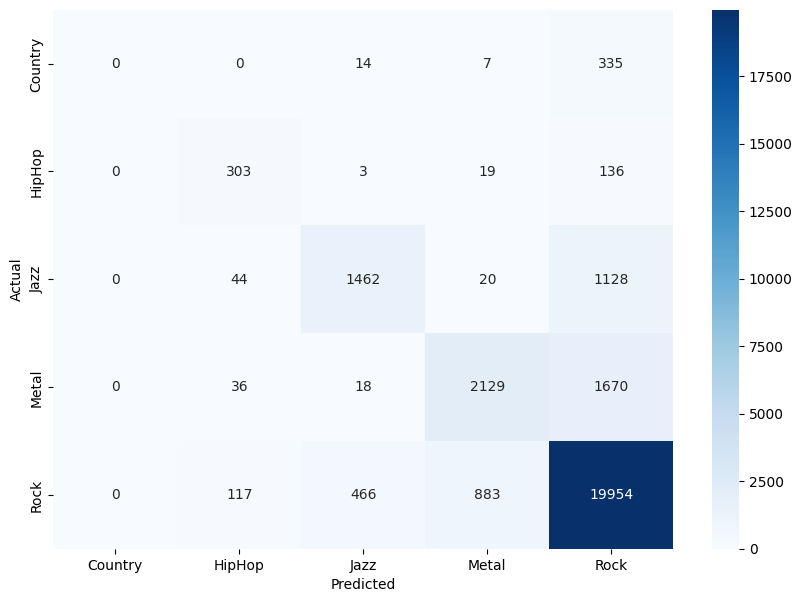

In [34]:
# Evaluate model 1 using validation data
evaluate_model(model_1, X_val_pad, y_val)


899/899 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Country       0.00      0.00      0.00       356
      HipHop       0.63      0.61      0.62       461
        Jazz       0.71      0.58      0.64      2654
       Metal       0.71      0.51      0.59      3853
        Rock       0.86      0.93      0.89     21420

    accuracy                           0.83     28744
   macro avg       0.58      0.53      0.55     28744
weighted avg       0.81      0.83      0.81     28744



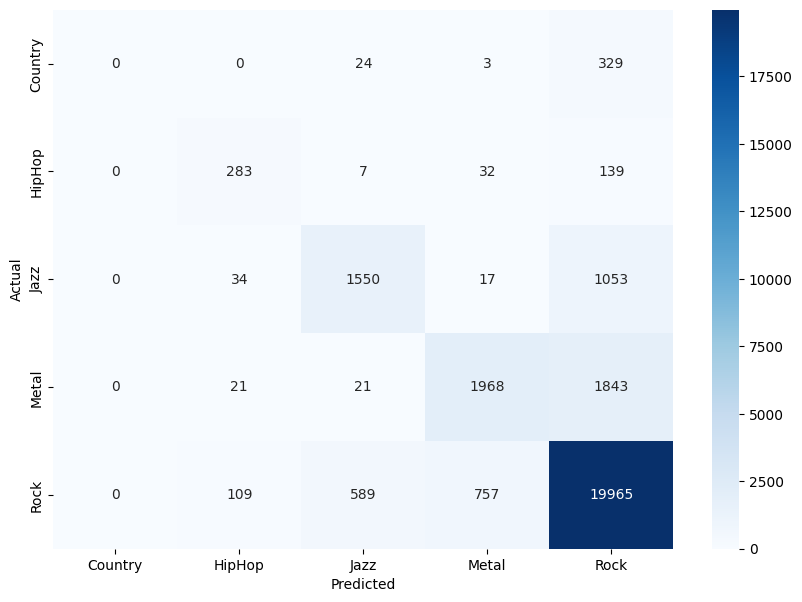

In [35]:
# Evaluate model 2 using validation data
evaluate_model(model_2, X_val_pad, y_val)

In [36]:
# Tokenize the test data lyrics using the tokenizer from the first set of parameters
X_test_seq = tokenizer.texts_to_sequences(test_data['Lyrics'])

# Pad the test sequences to match the input size of model 1
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)  

In [37]:
# Function to evaluate the model performance on the test set
def evaluate_test_model(model, X_test_pad, y_test):
    y_pred = np.argmax(model.predict(X_test_pad), axis=1)  # Predict the class labels for the test set
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))  # Print classification report
    cm = confusion_matrix(y_test, y_pred)  # Create confusion matrix
    plt.figure(figsize=(10, 7))  # Set figure size for heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)  # Plot confusion matrix
    plt.xlabel('Predicted')  # X-axis label
    plt.ylabel('Actual')  # Y-axis label
    plt.show()  # Show plot

In [38]:
# Get the true labels for the test data
y_test = test_data['Genre']

Evaluation of Model 1 on Test Data:
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00       810
      HipHop       0.97      0.68      0.80       960
        Jazz       0.81      0.33      0.46       660
       Metal       0.73      0.63      0.68       810
        Rock       0.41      0.88      0.56      1410

    accuracy                           0.57      4650
   macro avg       0.58      0.50      0.50      4650
weighted avg       0.57      0.57      0.52      4650



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


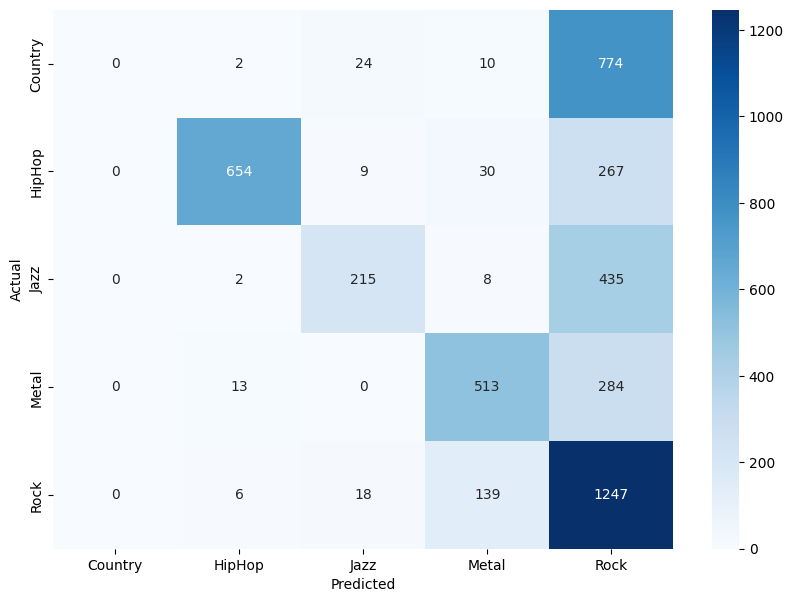

In [39]:
# Evaluate model 1 on the test data
print("Evaluation of Model 1 on Test Data:")
evaluate_test_model(model_1, X_test_pad, y_test)

Evaluation of Model 2 on Test Data:
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00       810
      HipHop       0.95      0.63      0.76       960
        Jazz       0.74      0.36      0.48       660
       Metal       0.73      0.56      0.64       810
        Rock       0.41      0.90      0.57      1410

    accuracy                           0.55      4650
   macro avg       0.57      0.49      0.49      4650
weighted avg       0.56      0.55      0.51      4650



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


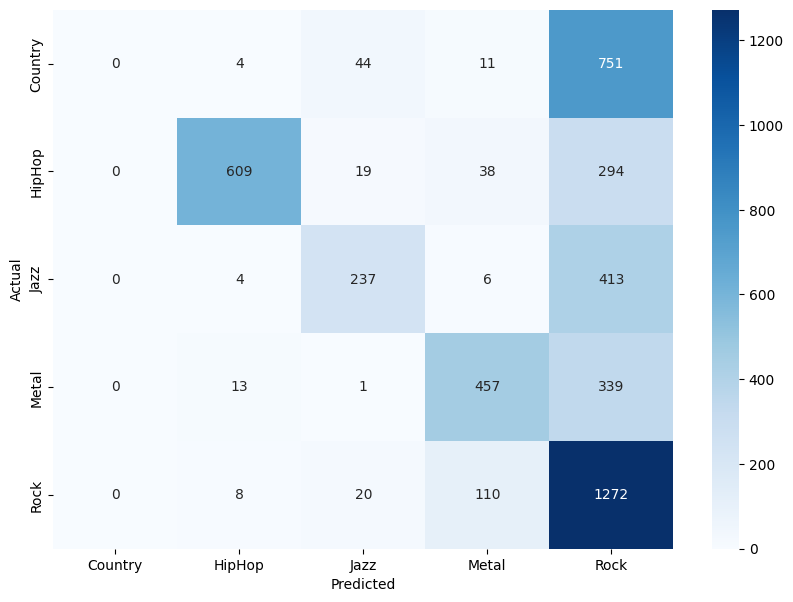

In [40]:
# Evaluate model 2 on the test data
print("Evaluation of Model 2 on Test Data:")
evaluate_test_model(model_2, X_test_pad, y_test)

# Model Comparison

| Model | Accuracy |  
|-------|----------|
| LSTM Single Layer | 57% |
| LSTM Double Layer | 55% |
|Logistic Regression ( Count Vectorization) | 58% |
| Logistic Regression (TF-IDF Vectorization) | 63% |  
| Random Forest (Count Vectorization) | 44% |
| Random Forest (TF-IDF Vectorization) | 44% |
| Support Vector Classifier (Count Vectorization) | 64% |
| Support Vector Classifier (TF-IDF Vectorization) | 67% |


*Conclusion:* **The Support Vector Classifier (SVC) demonstrated the best performance in both Count Vectorization and TF-IDF Vectorization, with accuracies of 64% and 67%, respectively, outperforming all other models. Logistic Regression also performed well, especially with TF-IDF Vectorization, but fell slightly short of SVC. LSTM models showed moderate results, with the single-layer variant outperforming the double-layer, suggesting that deeper architectures did not provide a significant boost in this context. Random Forest consistently delivered the lowest accuracy, indicating that it may not be well-suited for this text classification task.**